In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

sns.set_style('white')
%matplotlib inline

In [2]:
air = pd.read_csv('assets/datasets/airport_operations.csv')
air.columns = [c.replace(' ','_').replace('-','_') for c in air.columns]
air.head(2)

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [3]:
delay = air.average_airport_departure_delay.values

In [5]:
mean_delay = np.mean(delay)
print mean_delay

16.2499643282


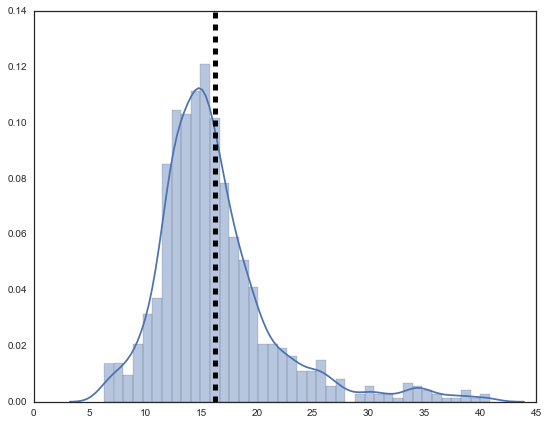

In [13]:
fig = plt.figure(figsize=(9,7))
ax = fig.gca()

ax = sns.distplot(delay, bins=40, ax=ax)
ax.axvline(mean_delay, lw=5, ls='dashed', color='black')

plt.show()

In [7]:
number_obs = len(delay)
print number_obs

841


In [8]:
delay_subset = np.random.choice(delay, replace=False, size=50)

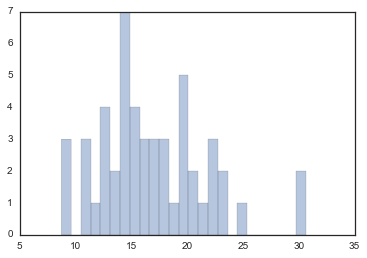

In [15]:
sns.distplot(delay_subset, bins=25, norm_hist=False, kde=False)

In [18]:
weak_prior = stats.norm(20, 10)
strong_prior = stats.norm(20, 1)

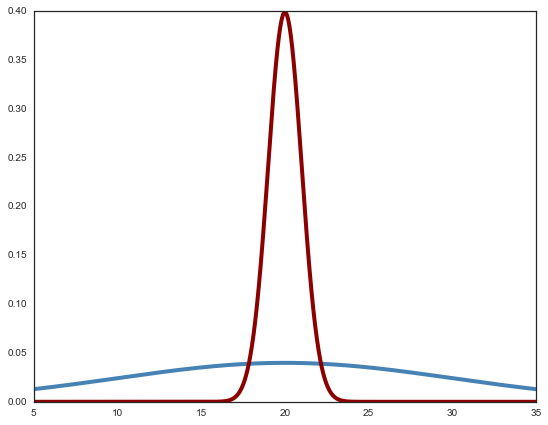

In [20]:
fig = plt.figure(figsize=(9,7))
ax = fig.gca()

minute_range = np.linspace(5, 35, 30*200)

weak_pdf = weak_prior.pdf(minute_range)
strong_pdf = strong_prior.pdf(minute_range)

ax.plot(minute_range, weak_pdf, color='steelblue', lw=4)
ax.plot(minute_range, strong_pdf, color='darkred', lw=4)

plt.show()

In [34]:
# to convert log likelihood to normal likelihood just use np.exp()
delay_loglikes = log_likelihood(delay_subset, 20, stats.norm, 10)
delay_likes = likelihood(delay_subset, 20, stats.norm, 10)

weak_likelihood = np.prod(np.exp(delay_loglikes))
print weak_likelihood

2.99595957215e-74


In [35]:
strong_loglikes = log_likelihood(delay_subset, 20, stats.norm, 1)

strong_likelihood = np.prod(np.exp(strong_loglikes))
print strong_likelihood

0.0


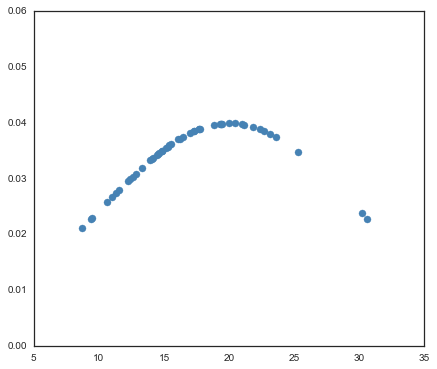

In [27]:
plt.figure(figsize=(7,6))

plt.scatter(delay_subset, delay_likelihood_weakprior, color='steelblue', s=50)

plt.show()

In [53]:
# likelihood:
# P(data | P(statistic))
# here statistic is just going to be the mean delay, the statistic we are measuring
# P(statistic) is our prior belief about what the distribution of mean delays are
# data is our observed flight delays

# prior_distribution is the distribution form of our beliefs about delays
# prior_std is the standard deviation (scale) of that prior belief distribution
def log_likelihood(data, statistic, prior_distribution, prior_std):
    prior = prior_distribution(statistic, prior_std)
    loglike = prior.logpdf(data)
    return np.sum(loglike)

# just the non-log version of the above (for your reference):
def likelihood(data, statistic, prior_distribution, prior_std):
    prior = prior_distribution(statistic, prior_std)
    like = prior.pdf(data)
    return like

# get log pdf for single means, given a prior statistic (mean) and standard deviation
def prior_logpdf(statistic, prior_distribution, prior_statistic, prior_std):
    prior = prior_distribution(prior_statistic, prior_std)
    statistic_logpdf = prior.logpdf(statistic)
    return statistic_logpdf

# get the distance for our next shift of the prior distribution:
def proposal(statistic, proposal_distribution, step_size):
    dist = proposal_distribution(statistic, step_size)
    new_proposed_statistic = dist.rvs()
    return new_proposed_statistic

In [54]:
def metropolis_sampler(data, statistic, prior_distribution, prior_statistic, prior_std,
                       proposal_distribution, proposal_avg_step):
    
    current_loglike = log_likelihood(data, statistic, prior_distribution, prior_std)
    current_prior_loglike = prior_logpdf(statistic, prior_distribution, prior_statistic, prior_std)
    
    proposed_shift = proposal(statistic, proposal_distribution, proposal_avg_step)
    proposed_loglike = log_likelihood(data, proposed_shift, prior_distribution, prior_std)
    proposed_prior_loglike = prior_logpdf(proposed_shift, prior_distribution, prior_statistic, prior_std)
    
    current_posterior_numerator_loglike = current_loglike + current_prior_loglike
    proposed_posterior_numerator_loglike = proposed_loglike + proposed_prior_loglike
    
    acceptance_criterion = np.exp(proposed_posterior_numerator_loglike - current_posterior_numerator_loglike)
    
    accept = acceptance_criterion > np.random.rand()
    
    if accept:
        return proposed_shift
    else:
        return statistic
    

In [55]:
def markov_chain_monte_carlo(data, initial_statistic,
                             prior_distribution, prior_statistic, prior_std,
                             proposal_distribution, proposal_avg_step,
                             iterations=1000):
    
    statistic_posterior = [initial_statistic]
    
    current_statistic = initial_statistic
    
    for i in range(iterations):
        
        current_statistic = metropolis_sampler(data, current_statistic, prior_distribution, 
                                               prior_statistic, prior_std,
                                               proposal_distribution, proposal_avg_step)
        
        statistic_posterior.append(current_statistic)
        
    return statistic_posterior
    

In [101]:
original_prior_mean = 20
original_prior_std = 7

prior_distribution = stats.norm
proposal_distribution = stats.norm

proposal_avg_step = 1.
initial_statistic = 20.
iterations = 500

In [102]:
posterior_mean_delay = markov_chain_monte_carlo(delay, initial_statistic,
                                                prior_distribution, original_prior_mean, original_prior_std,
                                                proposal_distribution, proposal_avg_step,
                                                iterations=iterations)

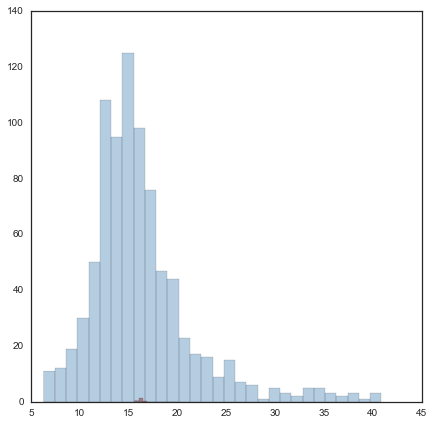

In [103]:
plt.figure(figsize=(7,7))

plt.hist(delay, color='steelblue', alpha=0.4, bins=30, normed=False)
plt.hist(posterior_mean_delay, color='darkred', alpha=0.4, bins=10, normed=True)

plt.show()

In [104]:
print np.mean(posterior_mean_delay), np.mean(delay_subset)

16.2885384752 16.8844


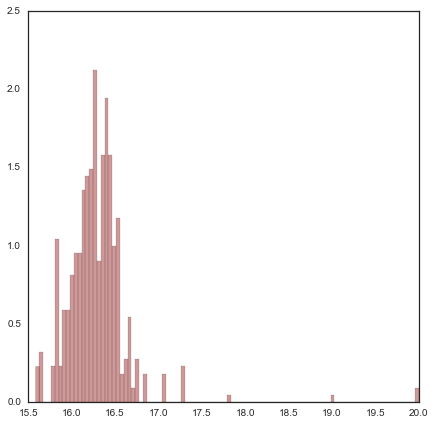

In [105]:
plt.figure(figsize=(7,7))
plt.hist(posterior_mean_delay, color='darkred', alpha=0.4, bins=100, normed=True)
plt.show()